<a href="https://colab.research.google.com/github/msawdon/marketing-ai/blob/main/Analytics_360_Propensity_Model_with_SciKit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Future Purchases with Analytics 360

## Introduction
This notebook walks through creating a propensity model using Analytics 360 data. The model will predict the probability of a site visitor returning in the future to make a purchase.

The purchase propensity productions from this model can be used to segment site visitors for remarketing campaigns. Users with higher purchase propensity can be targeted with higher advertising bids and frequency to maximize return on ad spend (ROAS.)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/msawdon/marketing-ai/blob/main/Analytics%20360%20Propensity%20Model%20with%20SciKit-Learn.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

## Step 1 - Install dependencies

In [ ]:
!pip install pandas-gbq

In [ ]:
!pip install google-cloud-bigquery-storage

In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import google.auth
import sklearn as sk

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.cloud import bigquery


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout

## Step 2 - Import data from BigQuery

Provide your user credentials to the runtime and provide a Google Cloud project ID to run BigQuery jobs.

In [ ]:
# Authentication for Colab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
project_id = "msawdon-165920" #@param {type: "string"}

### Option 1 - IPython Magics for BigQuery
This first options shows you how to import data from BigQuery using magic commands

In [ ]:
%%bigquery df_magic --project $project_id
WITH purchases AS (
SELECT
  fullVisitorId,
  MAX(CASE WHEN totals.transactions > 0 THEN 1 ELSE 0 END) AS purchased,
  MAX(CASE WHEN totals.transactions > 0 THEN date END) AS last_purchase_date
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY
  fullVisitorId),

visits AS (
SELECT
  fullVisitorId,
  visitNumber,
  visitId,
  visitStartTime,
  channelGrouping,
  socialEngagementType,
  date,
  COALESCE(totals.visits,0) AS visits,
  COALESCE(totals.hits,0) AS hits,
  COALESCE(totals.pageviews,0) AS pageviews,
  COALESCE(totals.timeOnSite,0) AS timeOnSite,
  COALESCE(totals.bounces,0) AS bounces,
  COALESCE(totals.transactions,0) AS transactions,
  COALESCE(totals.transactionRevenue,0) AS transactionRevenue,
  COALESCE(totals.newVisits,0) AS newVisits,
  COALESCE(totals.totalTransactionRevenue,0) AS totalTransactionRevenue,
  trafficSource.referralPath,
  trafficSource.campaign,
  trafficSource.source,
  trafficSource.medium,
  trafficSource.keyword,
  trafficSource.adContent,
  trafficSource.isTrueDirect,
  device.browser,
  device.operatingSystem,
  device.isMobile,
  device.deviceCategory,
  geoNetwork.continent,
  geoNetwork.subContinent,
  geoNetwork.country,
  geoNetwork.region,
  geoNetwork.metro,
  geoNetwork.city
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
),

hits AS (

SELECT
  visitId,
  MAX(hits.hitNumber) AS hits_COUNT,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Shopping Cart%" THEN 1 ELSE 0 END) AS funnel_view_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Checkout Your Information%" THEN 1 ELSE 0 END) AS funnel_review_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Payment Method%" THEN 1 ELSE 0 END) AS funnel_payment_method,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Men's%" THEN 1 ELSE 0 END) AS viewed_mens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Women's%" THEN 1 ELSE 0 END) AS viewed_womens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Kids' Apparel%" THEN 1 ELSE 0 END) AS viewed_kids,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Bags%" THEN 1 ELSE 0 END) AS viewed_bags,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Drinkware%" THEN 1 ELSE 0 END) AS viewed_drinkware,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Office%" THEN 1 ELSE 0 END) AS viewed_office,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Lifestyle%" THEN 1 ELSE 0 END) AS viewed_lifestyle,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Accessories%" THEN 1 ELSE 0 END) AS viewed_accessories,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Electronics%" THEN 1 ELSE 0 END) AS viewed_electronics,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Android%" THEN 1 ELSE 0 END) AS viewed_android,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%YouTube%" THEN 1 ELSE 0 END) AS viewed_youtube,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Google%" THEN 1 ELSE 0 END) AS viewed_google,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%The Google Merchandise Store - My Account%" THEN 1 ELSE 0 END) AS logged_in,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Frequently Asked Questions%" THEN 1 ELSE 0 END) AS viewed_faqs,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Quickview Click%" THEN 1 ELSE 0 END) AS quickview_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Add to Cart%" THEN 1 ELSE 0 END) AS add_to_cart_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Product Click%" THEN 1 ELSE 0 END) AS product_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Remove from Cart%" THEN 1 ELSE 0 END) AS remove_from_cart_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "1" THEN 1 ELSE 0 END) AS product_list_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "2" THEN 1 ELSE 0 END) AS product_detail_view
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga, UNNEST(hits) hits
GROUP BY
  visitId
),

sessions AS (
SELECT
  visits.*,
  hits.* EXCEPT(visitId)

FROM
  visits
LEFT JOIN
  hits
ON
  visits.visitId = hits.visitId
)


SELECT
  purchases.fullVisitorId AS fullVisitorId,
  purchased,
  CASE WHEN last_purchase_date IS null THEN MAX(sessions.date) ELSE last_purchase_date END AS last_visit,
  MAX(CASE WHEN browser LIKE "%Chrome%" THEN 1 ELSE 0 END) AS chrome,
  MAX(CASE WHEN operatingSystem LIKE "%Windows%" THEN 1 ELSE 0 END) AS windows,
  MAX(CASE WHEN isMobile IS TRUE THEN 1 ELSE 0 END) AS isMobile,
  MAX(CASE WHEN region LIKE "%California%" THEN 1 ELSE 0 END) AS California,
  MAX(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit_SUM,
  SUM(visits) AS visits_SUM,
  SUM(hits) AS hits_SUM,
  SUM(pageviews) AS pageviews_SUM,
  SUM(timeOnSite) AS timeOnSite_SUM,
  SUM(transactions) AS transactions_SUM,
  SUM(transactionRevenue) AS transaction_revenue_SUM,
  MAX(CASE WHEN newVisits = 0 THEN 1 ELSE 0 END) AS returning_visitor,
  MAX(funnel_view_cart) AS funnel_view_cart,
  SUM(funnel_view_cart) AS funnel_view_cart_SUM,
  MAX(funnel_review_cart) AS funnel_review_cart,
  SUM(funnel_review_cart) AS funnel_review_cart_SUM,
  MAX(funnel_payment_method) AS funnel_payment_method,
  SUM(funnel_payment_method) AS funnel_payment_method_SUM,
  MAX(viewed_mens) AS viewed_mens,
  SUM(viewed_mens) AS viewed_mens_SUM,
  MAX(viewed_womens) AS viewed_womens,
  SUM(viewed_womens) AS viewed_womens_SUM,
  MAX(viewed_kids) AS viewed_kids,
  SUM(viewed_kids) AS viewed_kids_SUM,
  MAX(viewed_bags) AS viewed_bags,
  SUM(viewed_bags) AS viewed_bags_SUM,
  MAX(viewed_drinkware) AS viewed_drinkware,
  SUM(viewed_drinkware) AS viewed_drinkware_SUM,
  MAX(viewed_office) AS viewed_office,
  SUM(viewed_office) AS viewed_office_SUM,
  MAX(viewed_lifestyle) AS viewed_lifestyle,
  SUM(viewed_lifestyle) AS viewed_lifestyle_SUM,
  MAX(viewed_accessories) AS viewed_accessories,
  SUM(viewed_accessories) AS viewed_accessories_SUM,
  MAX(viewed_electronics) AS viewed_electronics,
  SUM(viewed_electronics) AS viewed_electronics_SUM,
  MAX(viewed_android) AS viewed_android,
  SUM(viewed_android) AS viewed_android_SUM,
  MAX(viewed_youtube) AS viewed_youtube,
  SUM(viewed_youtube) AS viewed_youtube_SUM,
  MAX(viewed_google) AS viewed_google,
  SUM(viewed_google) AS viewed_google_SUM,
  MAX(logged_in) AS logged_in,
  SUM(logged_in) AS logged_in_SUM,
  MAX(viewed_faqs) AS viewed_faqs,
  SUM(viewed_faqs) AS viewed_faqs_SUM,
  MAX(quickview_click) AS quickview_click,
  SUM(quickview_click) AS quickview_click_SUM,
  MAX(add_to_cart_click) AS add_to_cart_click,
  SUM(add_to_cart_click) AS add_to_cart_click_SUM,
  MAX(product_click) AS product_click,
  SUM(product_click) AS product_click_SUM,
  MAX(remove_from_cart_click) AS remove_from_cart_click,
  SUM(remove_from_cart_click) AS remove_from_cart_click_SUM,
  MAX(product_list_click) AS product_list_click,
  SUM(product_list_click) AS product_list_click_SUM,
  MAX(product_detail_view) AS product_detail_view,
  SUM(product_detail_view) AS product_detail_view_SUM
FROM
  purchases
LEFT JOIN
  sessions
ON
  sessions.fullVisitorId = purchases.fullVisitorId
WHERE
  DATE_DIFF(PARSE_DATE('%Y%m%d',purchases.last_purchase_date),PARSE_DATE('%Y%m%d',sessions.date),DAY) <= 30
  OR purchases.last_purchase_date IS null
GROUP BY
  fullVisitorId, purchased, last_purchase_date

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_magic.head()

,fullVisitorId,purchased,last_visit,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM
0,1767680733201031011,0,20170509,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9323935233532568010,0,20160929,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,692590136109880471,0,20161003,1,0,1,1,0,0,1,...,0,0,0,0,0,0,1,1,1,1
3,1140660499231174129,0,20170323,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9205931142817587818,0,20161029,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Option 2 - Pandas GBQ
This second option shows you how to import data from BigQuery using the pandas gbq library. This is an open source library that leverages the BigQuery client library (shown as a third option below) to query data from BQ and store the results as a dataframe.

In [ ]:
sql = """
WITH purchases AS (
SELECT
  fullVisitorId,
  MAX(CASE WHEN totals.transactions > 0 THEN 1 ELSE 0 END) AS purchased,
  MAX(CASE WHEN totals.transactions > 0 THEN date END) AS last_purchase_date
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY
  fullVisitorId),

visits AS (
SELECT
  fullVisitorId,
  visitNumber,
  visitId,
  visitStartTime,
  channelGrouping,
  socialEngagementType,
  date,
  COALESCE(totals.visits,0) AS visits,
  COALESCE(totals.hits,0) AS hits,
  COALESCE(totals.pageviews,0) AS pageviews,
  COALESCE(totals.timeOnSite,0) AS timeOnSite,
  COALESCE(totals.bounces,0) AS bounces,
  COALESCE(totals.transactions,0) AS transactions,
  COALESCE(totals.transactionRevenue,0) AS transactionRevenue,
  COALESCE(totals.newVisits,0) AS newVisits,
  COALESCE(totals.totalTransactionRevenue,0) AS totalTransactionRevenue,
  trafficSource.referralPath,
  trafficSource.campaign,
  trafficSource.source,
  trafficSource.medium,
  trafficSource.keyword,
  trafficSource.adContent,
  trafficSource.isTrueDirect,
  device.browser,
  device.operatingSystem,
  device.isMobile,
  device.deviceCategory,
  geoNetwork.continent,
  geoNetwork.subContinent,
  geoNetwork.country,
  geoNetwork.region,
  geoNetwork.metro,
  geoNetwork.city
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
),

hits AS (

SELECT
  visitId,
  MAX(hits.hitNumber) AS hits_COUNT,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Shopping Cart%" THEN 1 ELSE 0 END) AS funnel_view_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Checkout Your Information%" THEN 1 ELSE 0 END) AS funnel_review_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Payment Method%" THEN 1 ELSE 0 END) AS funnel_payment_method,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Men's%" THEN 1 ELSE 0 END) AS viewed_mens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Women's%" THEN 1 ELSE 0 END) AS viewed_womens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Kids' Apparel%" THEN 1 ELSE 0 END) AS viewed_kids,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Bags%" THEN 1 ELSE 0 END) AS viewed_bags,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Drinkware%" THEN 1 ELSE 0 END) AS viewed_drinkware,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Office%" THEN 1 ELSE 0 END) AS viewed_office,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Lifestyle%" THEN 1 ELSE 0 END) AS viewed_lifestyle,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Accessories%" THEN 1 ELSE 0 END) AS viewed_accessories,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Electronics%" THEN 1 ELSE 0 END) AS viewed_electronics,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Android%" THEN 1 ELSE 0 END) AS viewed_android,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%YouTube%" THEN 1 ELSE 0 END) AS viewed_youtube,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Google%" THEN 1 ELSE 0 END) AS viewed_google,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%The Google Merchandise Store - My Account%" THEN 1 ELSE 0 END) AS logged_in,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Frequently Asked Questions%" THEN 1 ELSE 0 END) AS viewed_faqs,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Quickview Click%" THEN 1 ELSE 0 END) AS quickview_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Add to Cart%" THEN 1 ELSE 0 END) AS add_to_cart_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Product Click%" THEN 1 ELSE 0 END) AS product_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Remove from Cart%" THEN 1 ELSE 0 END) AS remove_from_cart_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "1" THEN 1 ELSE 0 END) AS product_list_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "2" THEN 1 ELSE 0 END) AS product_detail_view
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga, UNNEST(hits) hits
GROUP BY
  visitId
),

sessions AS (
SELECT
  visits.*,
  hits.* EXCEPT(visitId)

FROM
  visits
LEFT JOIN
  hits
ON
  visits.visitId = hits.visitId
)


SELECT
  purchases.fullVisitorId AS fullVisitorId,
  purchased,
  CASE WHEN last_purchase_date IS null THEN MAX(sessions.date) ELSE last_purchase_date END AS last_visit,
  MAX(CASE WHEN browser LIKE "%Chrome%" THEN 1 ELSE 0 END) AS chrome,
  MAX(CASE WHEN operatingSystem LIKE "%Windows%" THEN 1 ELSE 0 END) AS windows,
  MAX(CASE WHEN isMobile IS TRUE THEN 1 ELSE 0 END) AS isMobile,
  MAX(CASE WHEN region LIKE "%California%" THEN 1 ELSE 0 END) AS California,
  MAX(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit_SUM,
  SUM(visits) AS visits_SUM,
  SUM(hits) AS hits_SUM,
  SUM(pageviews) AS pageviews_SUM,
  SUM(timeOnSite) AS timeOnSite_SUM,
  SUM(transactions) AS transactions_SUM,
  SUM(transactionRevenue) AS transaction_revenue_SUM,
  MAX(CASE WHEN newVisits = 0 THEN 1 ELSE 0 END) AS returning_visitor,
  MAX(funnel_view_cart) AS funnel_view_cart,
  SUM(funnel_view_cart) AS funnel_view_cart_SUM,
  MAX(funnel_review_cart) AS funnel_review_cart,
  SUM(funnel_review_cart) AS funnel_review_cart_SUM,
  MAX(funnel_payment_method) AS funnel_payment_method,
  SUM(funnel_payment_method) AS funnel_payment_method_SUM,
  MAX(viewed_mens) AS viewed_mens,
  SUM(viewed_mens) AS viewed_mens_SUM,
  MAX(viewed_womens) AS viewed_womens,
  SUM(viewed_womens) AS viewed_womens_SUM,
  MAX(viewed_kids) AS viewed_kids,
  SUM(viewed_kids) AS viewed_kids_SUM,
  MAX(viewed_bags) AS viewed_bags,
  SUM(viewed_bags) AS viewed_bags_SUM,
  MAX(viewed_drinkware) AS viewed_drinkware,
  SUM(viewed_drinkware) AS viewed_drinkware_SUM,
  MAX(viewed_office) AS viewed_office,
  SUM(viewed_office) AS viewed_office_SUM,
  MAX(viewed_lifestyle) AS viewed_lifestyle,
  SUM(viewed_lifestyle) AS viewed_lifestyle_SUM,
  MAX(viewed_accessories) AS viewed_accessories,
  SUM(viewed_accessories) AS viewed_accessories_SUM,
  MAX(viewed_electronics) AS viewed_electronics,
  SUM(viewed_electronics) AS viewed_electronics_SUM,
  MAX(viewed_android) AS viewed_android,
  SUM(viewed_android) AS viewed_android_SUM,
  MAX(viewed_youtube) AS viewed_youtube,
  SUM(viewed_youtube) AS viewed_youtube_SUM,
  MAX(viewed_google) AS viewed_google,
  SUM(viewed_google) AS viewed_google_SUM,
  MAX(logged_in) AS logged_in,
  SUM(logged_in) AS logged_in_SUM,
  MAX(viewed_faqs) AS viewed_faqs,
  SUM(viewed_faqs) AS viewed_faqs_SUM,
  MAX(quickview_click) AS quickview_click,
  SUM(quickview_click) AS quickview_click_SUM,
  MAX(add_to_cart_click) AS add_to_cart_click,
  SUM(add_to_cart_click) AS add_to_cart_click_SUM,
  MAX(product_click) AS product_click,
  SUM(product_click) AS product_click_SUM,
  MAX(remove_from_cart_click) AS remove_from_cart_click,
  SUM(remove_from_cart_click) AS remove_from_cart_click_SUM,
  MAX(product_list_click) AS product_list_click,
  SUM(product_list_click) AS product_list_click_SUM,
  MAX(product_detail_view) AS product_detail_view,
  SUM(product_detail_view) AS product_detail_view_SUM
FROM
  purchases
LEFT JOIN
  sessions
ON
  sessions.fullVisitorId = purchases.fullVisitorId
WHERE
  DATE_DIFF(PARSE_DATE('%Y%m%d',purchases.last_purchase_date),PARSE_DATE('%Y%m%d',sessions.date),DAY) BETWEEN 1 AND 30
  OR purchases.last_purchase_date IS null
GROUP BY
  fullVisitorId, purchased, last_purchase_date
  """

# Use the BigQuery Storage API to download results faster
df_pandas = pd.read_gbq(sql, project_id=project_id, use_bqstorage_api=True)

In [ ]:
df_pandas.head()

,fullVisitorId,purchased,last_visit,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM
0,6306118989143686875,0,20170122,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3690661613290023865,0,20161218,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4089549041324029007,0,20170604,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1618107181890504622,0,20170320,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2212470032263759791,0,20170329,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,1


### Option 3 - BigQuery Client Library (Prefered Option)
This third option shows you how to use the BigQuery client library directly to query the data and store it as a dataframe. This is the official library from Google.

In [ ]:
# Create a BigQuery client
client = bigquery.Client(project=project_id)

sql = """
WITH purchases AS (
SELECT
  fullVisitorId,
  MAX(CASE WHEN totals.transactions > 0 THEN 1 ELSE 0 END) AS purchased,
  MAX(CASE WHEN totals.transactions > 0 THEN date END) AS last_purchase_date
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY
  fullVisitorId),

visits AS (
SELECT
  fullVisitorId,
  visitNumber,
  visitId,
  visitStartTime,
  channelGrouping,
  socialEngagementType,
  date,
  COALESCE(totals.visits,0) AS visits,
  COALESCE(totals.hits,0) AS hits,
  COALESCE(totals.pageviews,0) AS pageviews,
  COALESCE(totals.timeOnSite,0) AS timeOnSite,
  COALESCE(totals.bounces,0) AS bounces,
  COALESCE(totals.transactions,0) AS transactions,
  COALESCE(totals.transactionRevenue,0) AS transactionRevenue,
  COALESCE(totals.newVisits,0) AS newVisits,
  COALESCE(totals.totalTransactionRevenue,0) AS totalTransactionRevenue,
  trafficSource.referralPath,
  trafficSource.campaign,
  trafficSource.source,
  trafficSource.medium,
  trafficSource.keyword,
  trafficSource.adContent,
  trafficSource.isTrueDirect,
  device.browser,
  device.operatingSystem,
  device.isMobile,
  device.deviceCategory,
  geoNetwork.continent,
  geoNetwork.subContinent,
  geoNetwork.country,
  geoNetwork.region,
  geoNetwork.metro,
  geoNetwork.city
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
),

hits AS (

SELECT
  visitId,
  MAX(hits.hitNumber) AS hits_COUNT,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Shopping Cart%" THEN 1 ELSE 0 END) AS funnel_view_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Checkout Your Information%" THEN 1 ELSE 0 END) AS funnel_review_cart,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Payment Method%" THEN 1 ELSE 0 END) AS funnel_payment_method,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Men's%" THEN 1 ELSE 0 END) AS viewed_mens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Women's%" THEN 1 ELSE 0 END) AS viewed_womens,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Kids' Apparel%" THEN 1 ELSE 0 END) AS viewed_kids,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Bags%" THEN 1 ELSE 0 END) AS viewed_bags,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Drinkware%" THEN 1 ELSE 0 END) AS viewed_drinkware,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Office%" THEN 1 ELSE 0 END) AS viewed_office,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Lifestyle%" THEN 1 ELSE 0 END) AS viewed_lifestyle,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Accessories%" THEN 1 ELSE 0 END) AS viewed_accessories,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Electronics%" THEN 1 ELSE 0 END) AS viewed_electronics,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Android%" THEN 1 ELSE 0 END) AS viewed_android,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%YouTube%" THEN 1 ELSE 0 END) AS viewed_youtube,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Google%" THEN 1 ELSE 0 END) AS viewed_google,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%The Google Merchandise Store - My Account%" THEN 1 ELSE 0 END) AS logged_in,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Frequently Asked Questions%" THEN 1 ELSE 0 END) AS viewed_faqs,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Quickview Click%" THEN 1 ELSE 0 END) AS quickview_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Add to Cart%" THEN 1 ELSE 0 END) AS add_to_cart_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Product Click%" THEN 1 ELSE 0 END) AS product_click,
  MAX(CASE WHEN hits.page.pageTitle LIKE "%Remove from Cart%" THEN 1 ELSE 0 END) AS remove_from_cart_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "1" THEN 1 ELSE 0 END) AS product_list_click,
  MAX(CASE WHEN hits.eCommerceAction.action_type LIKE "2" THEN 1 ELSE 0 END) AS product_detail_view
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga, UNNEST(hits) hits
GROUP BY
  visitId
),

sessions AS (
SELECT
  visits.*,
  hits.* EXCEPT(visitId)

FROM
  visits
LEFT JOIN
  hits
ON
  visits.visitId = hits.visitId
)


SELECT
  purchases.fullVisitorId AS fullVisitorId,
  purchased,
  CASE WHEN last_purchase_date IS null THEN MAX(sessions.date) ELSE last_purchase_date END AS last_visit,
  MAX(CASE WHEN browser LIKE "%Chrome%" THEN 1 ELSE 0 END) AS chrome,
  MAX(CASE WHEN operatingSystem LIKE "%Windows%" THEN 1 ELSE 0 END) AS windows,
  MAX(CASE WHEN isMobile IS TRUE THEN 1 ELSE 0 END) AS isMobile,
  MAX(CASE WHEN region LIKE "%California%" THEN 1 ELSE 0 END) AS California,
  MAX(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Direct%" THEN 1 ELSE 0 END) AS direct_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Organic Search%" THEN 1 ELSE 0 END) AS organic_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Referral%" THEN 1 ELSE 0 END) AS referral_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Affiliates%" THEN 1 ELSE 0 END) AS affiliates_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Paid Search%" THEN 1 ELSE 0 END) AS paid_search_visit_SUM,
  MAX(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit,
  SUM(CASE WHEN channelGrouping LIKE "%Social%" THEN 1 ELSE 0 END) AS social_visit_SUM,
  SUM(visits) AS visits_SUM,
  SUM(hits) AS hits_SUM,
  SUM(pageviews) AS pageviews_SUM,
  SUM(timeOnSite) AS timeOnSite_SUM,
  SUM(transactions) AS transactions_SUM,
  SUM(transactionRevenue) AS transaction_revenue_SUM,
  MAX(CASE WHEN newVisits = 0 THEN 1 ELSE 0 END) AS returning_visitor,
  MAX(funnel_view_cart) AS funnel_view_cart,
  SUM(funnel_view_cart) AS funnel_view_cart_SUM,
  MAX(funnel_review_cart) AS funnel_review_cart,
  SUM(funnel_review_cart) AS funnel_review_cart_SUM,
  MAX(funnel_payment_method) AS funnel_payment_method,
  SUM(funnel_payment_method) AS funnel_payment_method_SUM,
  MAX(viewed_mens) AS viewed_mens,
  SUM(viewed_mens) AS viewed_mens_SUM,
  MAX(viewed_womens) AS viewed_womens,
  SUM(viewed_womens) AS viewed_womens_SUM,
  MAX(viewed_kids) AS viewed_kids,
  SUM(viewed_kids) AS viewed_kids_SUM,
  MAX(viewed_bags) AS viewed_bags,
  SUM(viewed_bags) AS viewed_bags_SUM,
  MAX(viewed_drinkware) AS viewed_drinkware,
  SUM(viewed_drinkware) AS viewed_drinkware_SUM,
  MAX(viewed_office) AS viewed_office,
  SUM(viewed_office) AS viewed_office_SUM,
  MAX(viewed_lifestyle) AS viewed_lifestyle,
  SUM(viewed_lifestyle) AS viewed_lifestyle_SUM,
  MAX(viewed_accessories) AS viewed_accessories,
  SUM(viewed_accessories) AS viewed_accessories_SUM,
  MAX(viewed_electronics) AS viewed_electronics,
  SUM(viewed_electronics) AS viewed_electronics_SUM,
  MAX(viewed_android) AS viewed_android,
  SUM(viewed_android) AS viewed_android_SUM,
  MAX(viewed_youtube) AS viewed_youtube,
  SUM(viewed_youtube) AS viewed_youtube_SUM,
  MAX(viewed_google) AS viewed_google,
  SUM(viewed_google) AS viewed_google_SUM,
  MAX(logged_in) AS logged_in,
  SUM(logged_in) AS logged_in_SUM,
  MAX(viewed_faqs) AS viewed_faqs,
  SUM(viewed_faqs) AS viewed_faqs_SUM,
  MAX(quickview_click) AS quickview_click,
  SUM(quickview_click) AS quickview_click_SUM,
  MAX(add_to_cart_click) AS add_to_cart_click,
  SUM(add_to_cart_click) AS add_to_cart_click_SUM,
  MAX(product_click) AS product_click,
  SUM(product_click) AS product_click_SUM,
  MAX(remove_from_cart_click) AS remove_from_cart_click,
  SUM(remove_from_cart_click) AS remove_from_cart_click_SUM,
  MAX(product_list_click) AS product_list_click,
  SUM(product_list_click) AS product_list_click_SUM,
  MAX(product_detail_view) AS product_detail_view,
  SUM(product_detail_view) AS product_detail_view_SUM
FROM
  purchases
LEFT JOIN
  sessions
ON
  sessions.fullVisitorId = purchases.fullVisitorId
WHERE
  DATE_DIFF(PARSE_DATE('%Y%m%d',purchases.last_purchase_date),PARSE_DATE('%Y%m%d',sessions.date),DAY) BETWEEN 1 AND 30
  OR purchases.last_purchase_date IS null
GROUP BY
  fullVisitorId, purchased, last_purchase_date
  """

# Like the pandas-gbq version, use the BigQuery Storage API client to download results more quickly.
df = client.query(sql).result().to_dataframe()

In [ ]:
df.head()

,fullVisitorId,purchased,last_visit,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM
0,1457500949662851936,0,20170311,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8232499902762075805,0,20170517,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9423938437303849142,0,20170131,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3117139871471848487,0,20160916,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9291339601094927980,0,20160809,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The final dataframe contains record for each fullVisitorId in the Analytics 360 BigQuery Export.  The label we are trying to predict is "purchased."  In practice, you would use clientId instead of fullVisitorId because fullVisitorId isn't a dimension you can join with for the Analytics 360 data import feature.

## Step 3 - Data cleaning & EDA

In [ ]:
#Check fullVisitorId is distinct for each record
len(df) == len(df.groupby('fullVisitorId'))

True

In [ ]:
#Could check for duplicates this way too
df[df.duplicated(subset=['fullVisitorId'])].head()

,fullVisitorId,purchased,last_visit,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM


In [ ]:
#Check for null values
df_nulls = df[df.isnull().apply(lambda x: max(x), axis=1)]
df_nulls.head()

,fullVisitorId,purchased,last_visit,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM


In [ ]:
#Check class balance
print("Full dataframe: ", df.shape)
print("Data frame with only purchasers: ", df[df['purchased']>0].shape)

Full dataframe:  (708057, 72)
Data frame with only purchasers:  (3912, 72)


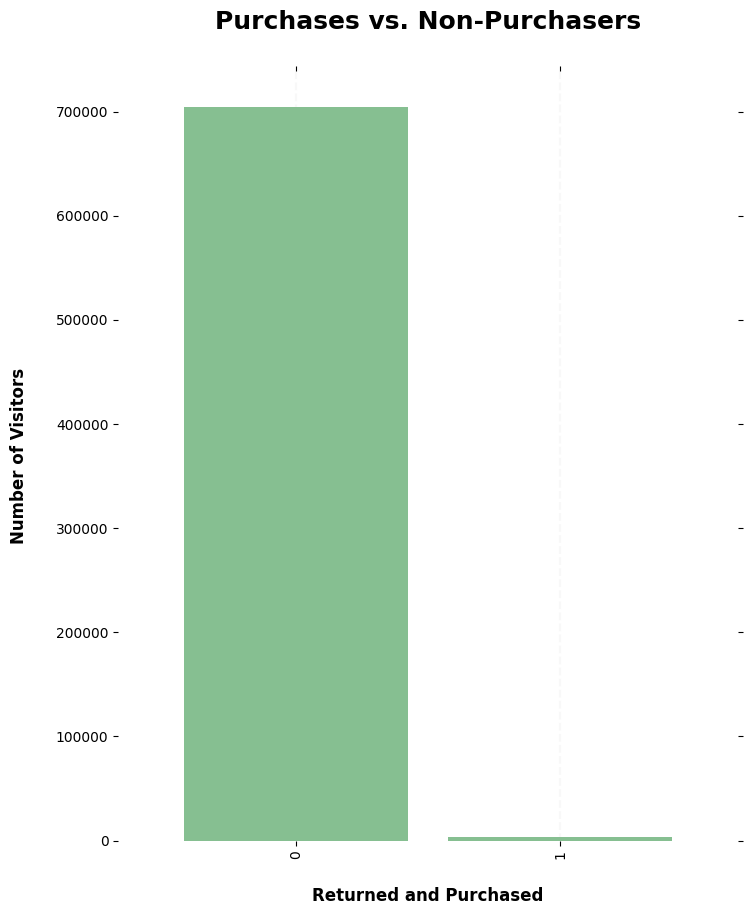

In [ ]:
#Visualize class imbalance
from matplotlib.ticker import StrMethodFormatter

balance = df.groupby('purchased')['fullVisitorId'].count()

ax = balance.plot(kind='bar', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="False", top="False", labelbottom="True", left="False", right="False", labelleft="True")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#Set title
ax.set_title("Purchases vs. Non-Purchasers", pad=30, weight='bold', size=18)

# Set x-axis label
ax.set_xlabel("Returned and Purchased", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Number of Visitors", labelpad=20, weight='bold', size=12)

# Format x-axis labels
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [ ]:
#Downsample non-purchasers
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.purchased==0]
df_minority = df[df.purchased==1]

n_samples = len(df_minority)

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=n_samples,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.purchased.value_counts()


0    3912
1    3912
Name: purchased, dtype: Int64

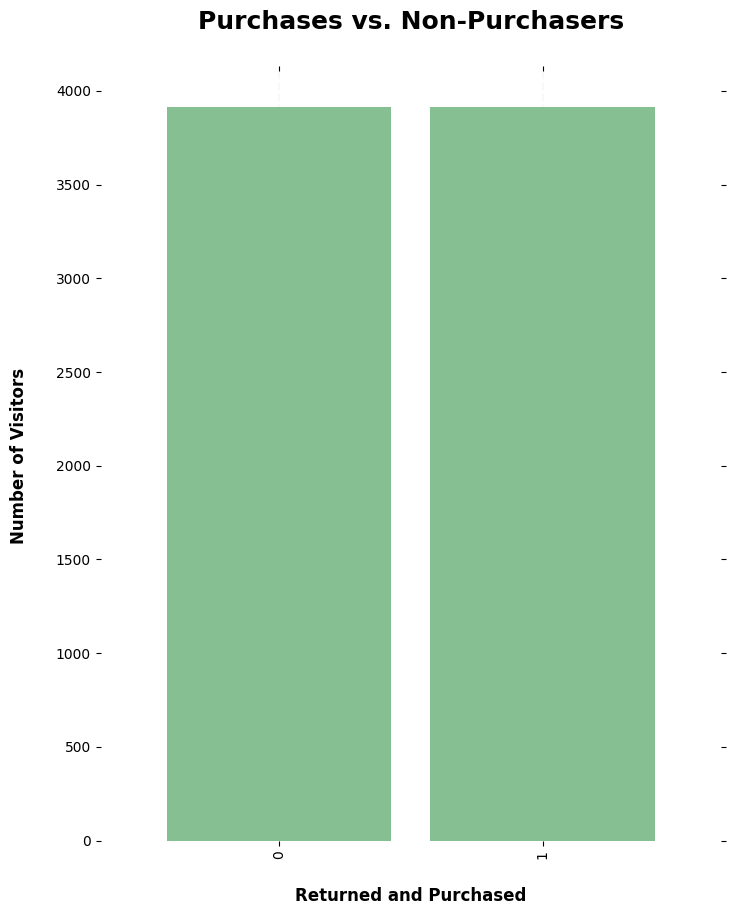

In [ ]:
#Visualize class balance
balance = df_downsampled.groupby('purchased')['fullVisitorId'].count()

ax = balance.plot(kind='bar', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="False", top="False", labelbottom="True", left="False", right="False", labelleft="True")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#Set title
ax.set_title("Purchases vs. Non-Purchasers", pad=30, weight='bold', size=18)

# Set x-axis label
ax.set_xlabel("Returned and Purchased", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Number of Visitors", labelpad=20, weight='bold', size=12)

# Format x-axis labels
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Step 4 - Preprocessing

In [ ]:
#Create training, testing and validation datasets
X = df_downsampled.drop('purchased', axis=1)
y = df_downsampled['purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=123)

visitors_train = X_train['fullVisitorId']
visitors_test = X_test['fullVisitorId']
visitors_val = X_val['fullVisitorId']

In [ ]:
X_train.describe()

,chrome,windows,isMobile,California,direct_visit,direct_visit_SUM,organic_search_visit,organic_search_visit_SUM,referral_visit,referral_visit_SUM,...,add_to_cart_click,add_to_cart_click_SUM,product_click,product_click_SUM,remove_from_cart_click,remove_from_cart_click_SUM,product_list_click,product_list_click_SUM,product_detail_view,product_detail_view_SUM
count,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,...,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0,6259.0
mean,0.790222,0.29174,0.168717,0.214251,0.172072,0.302285,0.374181,0.595303,0.306598,0.641956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.413964,0.655057,0.413964,0.654577
std,0.407183,0.4546,0.374532,0.410335,0.377473,1.046847,0.483949,1.291236,0.461118,1.370407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.492582,1.044723,0.492582,1.044182
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,30.0,1.0,27.0,1.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,1.0,14.0


In [ ]:
#Standardize inputs
from sklearn import preprocessing

scalar = preprocessing.StandardScaler()
scalar.fit(X_train)
standard_data = scalar.transform(X_train)
X_train = pd.DataFrame(standard_data, index=X_train.index, columns=X_train.columns)

scalar.fit(X_test)
standard_data = scalar.transform(X_test)
X_test = pd.DataFrame(standard_data, index=X_test.index, columns=X_test.columns)

scalar.fit(X_val)
standard_data = scalar.transform(X_val)
X_val = pd.DataFrame(standard_data, index=X_val.index, columns=X_val.columns)

In [ ]:
#Visualize correlations
#This isn't practical for >25 features
#sns.heatmap(X_train.corr(), annot = True)

In [ ]:
#Just pull top correlated pairs instead.
corr_pairs = X_train.corr().unstack().sort_values(ascending = False).drop_duplicates()
corr_pairs.head(25)

fullVisitorId              fullVisitorId                1.000000
product_list_click_SUM     product_detail_view_SUM      0.999781
pageviews_SUM              hits_SUM                     0.991310
viewed_faqs                viewed_faqs_SUM              0.932963
visits_SUM                 viewed_google_SUM            0.932821
viewed_android_SUM         social_visit_SUM             0.914732
funnel_review_cart_SUM     funnel_payment_method_SUM    0.907099
viewed_lifestyle_SUM       viewed_lifestyle             0.889526
funnel_review_cart         funnel_payment_method        0.867711
timeOnSite_SUM             pageviews_SUM                0.867028
funnel_review_cart         funnel_review_cart_SUM       0.854991
viewed_electronics_SUM     viewed_electronics           0.851724
funnel_payment_method_SUM  funnel_payment_method        0.850963
hits_SUM                   timeOnSite_SUM               0.847174
viewed_drinkware           viewed_drinkware_SUM         0.839096
viewed_office            

In [ ]:
mutual_info = feature_selection.mutual_info_classif(X_train,y_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info.head(20)

pageviews_SUM                0.283063
hits_SUM                     0.275179
timeOnSite_SUM               0.231838
product_list_click_SUM       0.192905
product_detail_view_SUM      0.183295
product_detail_view          0.179186
product_list_click           0.170318
funnel_view_cart_SUM         0.168519
funnel_view_cart             0.166317
returning_visitor            0.156923
referral_visit_SUM           0.132905
visits_SUM                   0.120660
referral_visit               0.117953
social_visit_SUM             0.103727
viewed_google_SUM            0.097421
funnel_payment_method_SUM    0.097277
funnel_payment_method        0.096937
social_visit                 0.096336
funnel_review_cart           0.091243
funnel_review_cart_SUM       0.086485
dtype: float64

<Axes: >

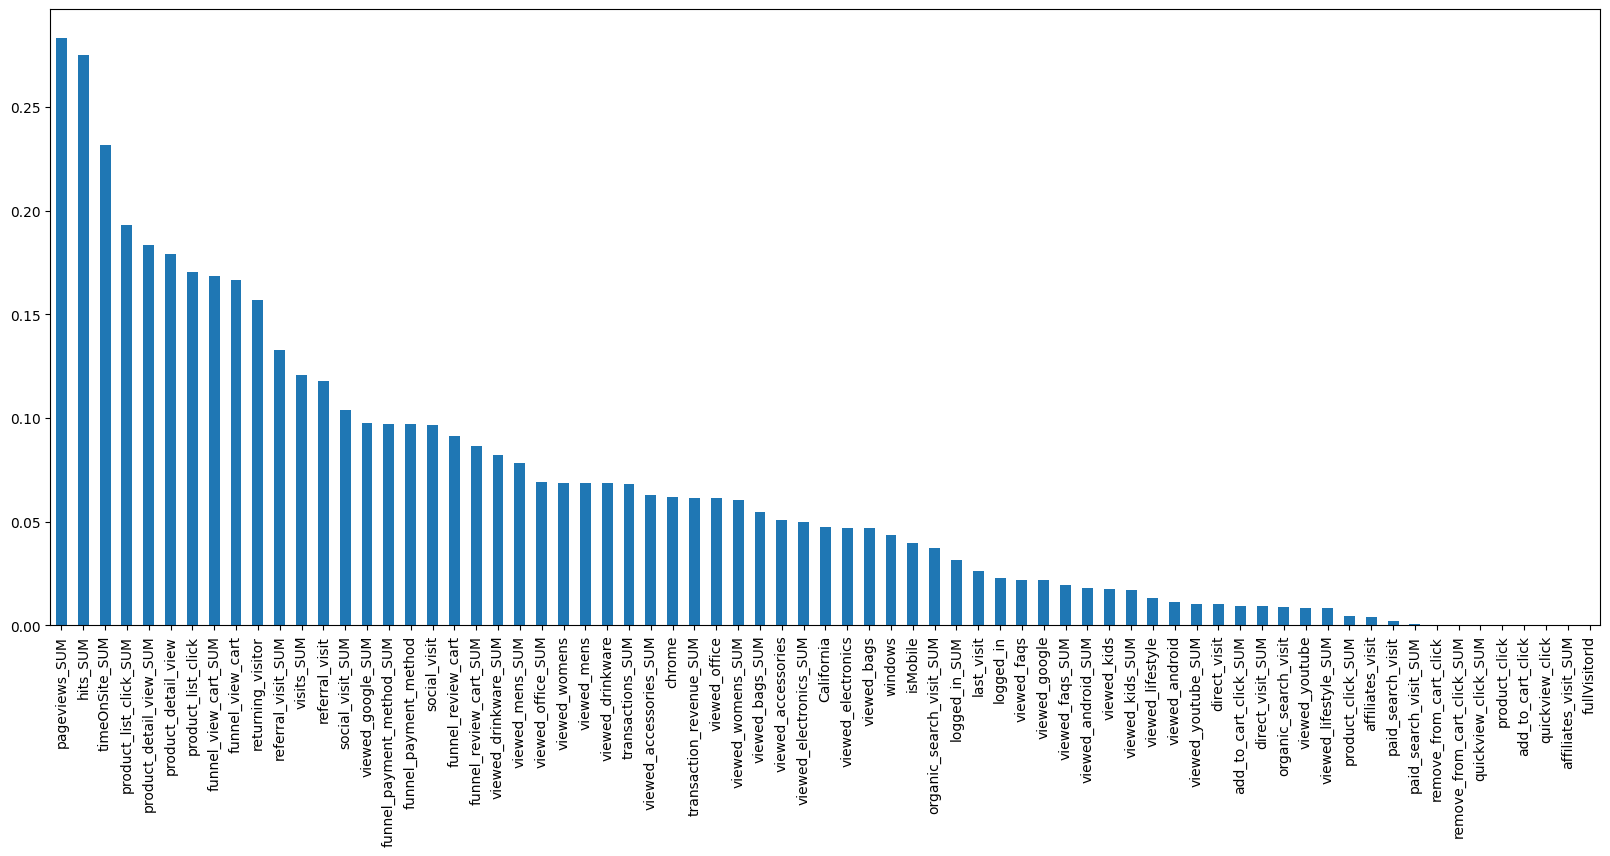

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))


<Axes: >

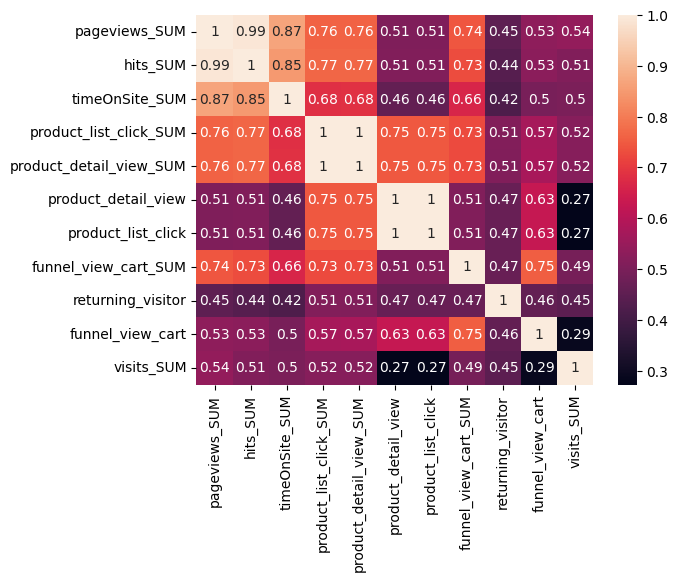

In [ ]:
#Picking top 11 features before drop-off
selected_features = [
    'pageviews_SUM',
    'hits_SUM',
    'timeOnSite_SUM',
    'product_list_click_SUM',
    'product_detail_view_SUM',
    'product_detail_view',
    'product_list_click',
    'funnel_view_cart_SUM',
    'returning_visitor',
    'funnel_view_cart',
    'visits_SUM'
                    ]

X_filtering = X_train[selected_features].copy()

sns.heatmap(X_filtering.corr(), annot = True)

<Axes: >

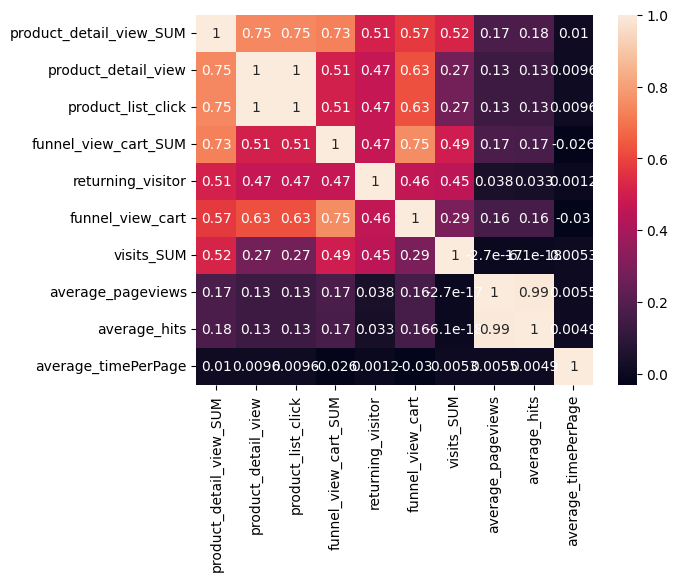

In [ ]:
#Lots of correlation so combining some variables
X_final = X_filtering.copy()

X_final['average_pageviews'] = X_final['pageviews_SUM']/X_final['visits_SUM']
X_final['average_hits'] = X_final['hits_SUM']/X_final['visits_SUM']
X_final['average_timePerPage'] = X_final['timeOnSite_SUM']/X_final['pageviews_SUM']
X_final = X_final.drop(columns=['pageviews_SUM','hits_SUM','timeOnSite_SUM','product_list_click_SUM'])

sns.heatmap(X_final.corr(), annot = True)

In [ ]:
X_final.head()

,product_detail_view_SUM,product_detail_view,product_list_click,funnel_view_cart_SUM,returning_visitor,funnel_view_cart,visits_SUM,average_pageviews,average_hits,average_timePerPage
625638,0.330833,1.189819,1.189819,-0.524794,-0.792089,-0.695361,-0.354063,0.693339,0.704166,1.260776
339634,-0.626931,-0.840464,-0.840464,-0.524794,-0.792089,-0.695361,-0.354063,0.983925,1.059084,1.066877
47750,-0.626931,-0.840464,-0.840464,-0.524794,1.262484,-0.695361,0.501071,-0.558366,-0.648046,1.180297
433098,-0.626931,-0.840464,-0.840464,-0.524794,-0.792089,-0.695361,-0.354063,1.468235,1.414002,0.949533
594313,5.119654,1.189819,1.189819,3.441021,1.262484,1.438102,8.197283,0.459550,0.411086,1.412189


In [ ]:
#Filter training, test and validation data for top features
#We did feature selection using the X_train data so we can just make a copy of the final dataframe for that

X_train = X_final.copy()
x_features = selected_features

X_test = X_test[x_features]
X_val = X_val[x_features]

X_test['average_pageviews'] = X_test['pageviews_SUM']/X_test['visits_SUM']
X_test['average_hits'] = X_test['hits_SUM']/X_test['visits_SUM']
X_test['average_timePerPage'] = X_test['timeOnSite_SUM']/X_test['pageviews_SUM']
X_test = X_test.drop(columns=['pageviews_SUM','hits_SUM','timeOnSite_SUM','product_list_click_SUM'])

X_val['average_pageviews'] = X_val['pageviews_SUM']/X_val['visits_SUM']
X_val['average_hits'] = X_val['hits_SUM']/X_val['visits_SUM']
X_val['average_timePerPage'] = X_val['timeOnSite_SUM']/X_val['pageviews_SUM']
X_val = X_val.drop(columns=['pageviews_SUM','hits_SUM','timeOnSite_SUM','product_list_click_SUM'])


<ipython-input-78-0313bc371dce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['average_pageviews'] = X_test['pageviews_SUM']/X_test['visits_SUM']
<ipython-input-78-0313bc371dce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['average_hits'] = X_test['hits_SUM']/X_test['visits_SUM']
<ipython-input-78-0313bc371dce>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

## Step 5 - Model training & testing

In [ ]:
logreg = sk.linear_model.LogisticRegression()
#features_to_include = ['pageviews_SUM']
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('accuracy on training data', logreg.score(X_train, y_train))
print('accuracy on test data', logreg.score(X_test, y_test))
print('roc auc on test data', auc)

accuracy on training data 0.8135484901741492
accuracy on test data 0.797923322683706
roc auc on test data 0.8336017067015085


In [ ]:
from sklearn import tree

DT_model = tree.DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

y_pred_proba = DT_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('accuracy on training data', DT_model.score(X_train, y_train))
print('accuracy on training data', DT_model.score(X_test, y_test))
print('roc auc on test data', auc)

accuracy on training data 0.9622942962134526
accuracy on training data 0.7412140575079872
roc auc on test data 0.7420132340819717


In [ ]:
DT_model = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)
DT_model.fit(X_train, y_train)

y_pred_proba = DT_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('accuracy on training data', DT_model.score(X_train, y_train))
print('accuracy on training data', DT_model.score(X_test, y_test))
print('roc auc on test data', auc)

accuracy on training data 0.834478351174309
accuracy on training data 0.8186900958466453
roc auc on test data 0.8626255847009318


In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=1000, max_depth=6)
random_forest_model.fit(X_train, y_train)

y_pred_proba = random_forest_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('accuracy on training data',random_forest_model.score(X_train, y_train))
print('accuracy on test data',random_forest_model.score(X_test, y_test))
print('roc auc on test data', auc)

accuracy on training data 0.8403898386323694
accuracy on test data 0.8138977635782748
roc auc on test data 0.8985242441950968


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(n_estimators=90, max_depth=5, min_samples_leaf=110)
gbm_model.fit(X_train, y_train)

y_pred_proba = gbm_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('accuracy on training data',gbm_model.score(X_train, y_train))
print('accuracy on test data',gbm_model.score(X_test, y_test))
print('roc auc on test data', auc)

accuracy on training data 0.8459817862278319
accuracy on test data 0.8115015974440895
roc auc on test data 0.8952233793608546


In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10,), activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(learning_rate=0.001), 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train.astype('float'), epochs=100, verbose=0)

#y_train_pred = model.predict_classes(X_train)
#y_test_pred = model.predict_classes(X_test)

y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

print("The Accuracy score on the Train set is:\t{:0.3f}".format(accuracy_score(y_train, y_train_pred)))
print("The Accuracy score on the Test set is:\t{:0.3f}".format(accuracy_score(y_test, y_test_pred)))

40/40 [==============================] - 0s 1ms/step
The Accuracy score on the Train set is:	0.834
The Accuracy score on the Test set is:	0.808


In [ ]:
#Check model statistics for XGBoost model...Should have done this for all models but...

y_pred = gbm_model.predict(X_test)
print("Evaluation Statistics")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("AUC ROC")
print(roc_auc_score(y_test,y_pred))

Evaluation Statistics
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       623
         1.0       0.80      0.84      0.82       629

    accuracy                           0.81      1252
   macro avg       0.81      0.81      0.81      1252
weighted avg       0.81      0.81      0.81      1252

Confusion Matrix
[[487 136]
 [100 529]]
AUC ROC
0.8113594663495524


Text(0.5, 23.52222222222222, 'Predicted label')

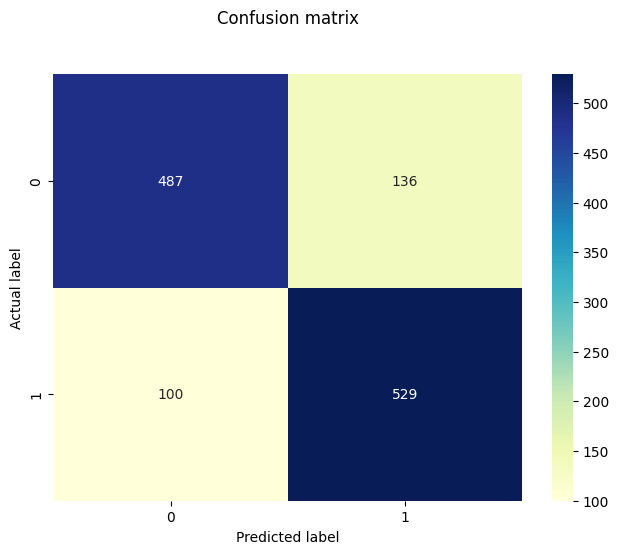

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

#visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), cmap="YlGnBu", annot=True ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#Final check on validation/holdout
print('The accuracy on validation data is: ',gbm_model.score(X_val, y_val))

The accuracy on validation data is:  0.8402555910543131


## Step 6 - Save model and push results to BigQuery

In [ ]:
#Save XGBoost model
gmb_model_fit = gbm_model.fit(X_train, y_train)

joblib.dump(gmb_model_fit, 'gmb_model.joblib')

['gmb_model.joblib']

In [ ]:
saved_model = joblib.load('gmb_model.joblib')

In [ ]:
data = X_val.copy()
predictions = saved_model.predict_proba(data)[:,1]

results = data.copy()
results['fullVisitorId'] = visitors_val
results['probability'] = predictions

results.head()

,product_detail_view_SUM,product_detail_view,product_list_click,funnel_view_cart_SUM,returning_visitor,funnel_view_cart,visits_SUM,average_pageviews,average_hits,average_timePerPage,fullVisitorId,probability
287086,-0.646978,-0.826315,-0.826315,-0.509507,-0.767354,-0.640242,-0.472745,1.245233,1.198647,0.903272,8843846942953000565,0.173304
579472,0.413253,1.210193,1.210193,-0.509507,-0.767354,-0.640242,-0.472745,0.185846,0.255263,4.737903,7505608687492467483,0.460915
34045,0.413253,1.210193,1.210193,0.605708,-0.767354,1.561909,-0.472745,-2.992313,-3.445704,0.962530,5429486512675747179,0.861842
426210,0.413253,1.210193,1.210193,1.720922,1.303179,1.561909,1.526839,0.061734,0.078246,1.616734,8806276575158015292,0.921477
474232,-0.646978,-0.826315,-0.826315,-0.509507,-0.767354,-0.640242,-0.472745,1.245233,1.198647,0.903272,0994503053108396446,0.173304


In [ ]:
probabilities = results[['fullVisitorId','probability']]

table_id = 'ga_project.results'

probabilities.to_gbq(project_id=project_id, destination_table=table_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 5412.01it/s]
